# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [39]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [40]:
# При необходимости добавляйте новые ячейки для кода или текста

In [41]:
!pip install sqlalchemy psycopg2-binary pandas

In [42]:

import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
try:
    from phik import phik_matrix
except ImportError:
    !pip install phik
    from phik import phik_matrix
    
# 3. Конфигурация подключения к базе данных
db_config = {
    'user': 'praktikum_student',          # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',              # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,                         # порт подключения
    'db': 'data-analyst-afisha'           # название базы данных
}

# 4. Формирование строки подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

# 5. Создание соединения с базой данных
engine = create_engine(connection_string)

# 6. Написание SQL-запроса
query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk AS order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  CASE
    WHEN LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk) IS NULL THEN NULL
    ELSE EXTRACT(DAY FROM (p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)))
  END AS days_since_prev,
  p.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p
LEFT JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

# 7. Выполнение запроса и загрузка в DataFrame
df = pd.read_sql_query(query, con=engine)

# 8. Просмотр результата
print(f'Размер датафрейма: {df.shape}')
print('\nПервые строки данных:')
print(df.head())

Размер датафрейма: (290611, 15)

Первые строки данных:
           user_id device_type_canonical  order_id   order_dt  \
0  0002849b70a3ce2                mobile   4359165 2024-08-20   
1  0005ca5e93f2cf4                mobile   7965605 2024-07-23   
2  0005ca5e93f2cf4                mobile   7292370 2024-10-06   
3  000898990054619                mobile   1139875 2024-07-13   
4  000898990054619                mobile    972400 2024-10-04   

             order_ts currency_code  revenue  tickets_count  days_since_prev  \
0 2024-08-20 16:08:03           rub  1521.94              4              NaN   
1 2024-07-23 18:36:24           rub   289.45              2              NaN   
2 2024-10-06 13:56:02           rub  1258.57              4             75.0   
3 2024-07-13 19:40:48           rub     8.49              2              NaN   
4 2024-10-04 22:33:15           rub  1390.41              3             83.0   

   event_id                            event_name event_type_main  \
0   

**Подключение прошло успешно, SQL запрос сработал**

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [43]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

На основе информации мы видим что в таблице:  
**290611 строк**  
**15 столбцов**  
Типы данных у всех столбцов - корректны.
Можно откорректировать битрейт некоторых столбцов по типу float64 & int64

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [44]:
df_kzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')


df_kzt['revenue_rub'] = df_kzt['nominal'] * df_kzt['curs']
print(df_kzt)
print(df_kzt.info())

           data  nominal     curs  cdx  revenue_rub
0    2024-01-10      100  19.9391  kzt      1993.91
1    2024-01-11      100  19.7255  kzt      1972.55
2    2024-01-12      100  19.5839  kzt      1958.39
3    2024-01-13      100  19.4501  kzt      1945.01
4    2024-01-14      100  19.4501  kzt      1945.01
..          ...      ...      ...  ...          ...
352  2024-12-27      100  19.2705  kzt      1927.05
353  2024-12-28      100  19.5105  kzt      1951.05
354  2024-12-29      100  19.4860  kzt      1948.60
355  2024-12-30      100  19.4860  kzt      1948.60
356  2024-12-31      100  19.4860  kzt      1948.60

[357 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         357 non-null    object 
 1   nominal      357 non-null    int64  
 2   curs         357 non-null    float64
 3   cdx          357 non-null    obje

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [45]:
print(df.isna().sum())

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64


Всё правильно, пропуски только в столбце **days_since_prev**

In [46]:

for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')
for column in ['revenue', 'days_since_prev']:
    df[column] = pd.to_numeric(df[column], downcast='float')

print(df.dtypes)

user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object


Преобразованны числовые типы данных по подходящему битрейту

In [47]:
print(df['device_type_canonical'].unique())
print(df['event_type_main'].unique())
print(df['currency_code'].unique())

['mobile' 'desktop']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['rub' 'kzt']


Категориальные и номинальыне значения корректны.
В категориях мероприятий можем заметить что есть категория "другое" которая может обозначать отсутсвие информации или же нет подходящей катерии.

In [48]:
print(df['tickets_count'].describe())

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


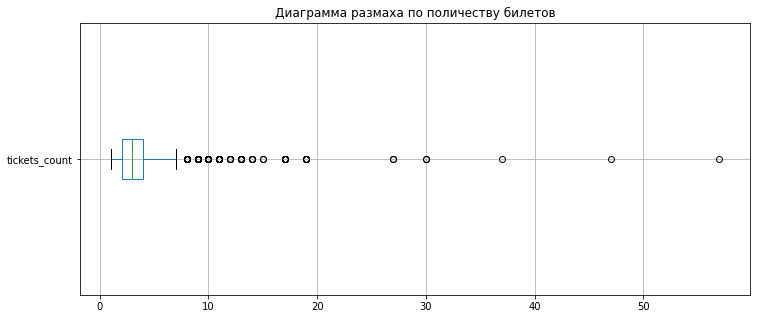

In [49]:
plt.figure(figsize=(12,5))
df.boxplot(column='tickets_count', vert=False, grid=True, figsize=(12,6))
plt.title('Диаграмма размаха по поличеству билетов')
plt.show()

Видно что большое количество выбросов:  
медиана - 3, среднее значение 2.7, когда максимальное значение 57.

На диаграмме наглядно видно выбросы.

Я предпологаю что покупки с большим количество билетов обусловленны покупкой билетов для каких либо организаций либо же недобросовестные пользователи скупают в огромных объёмах билеты для дальнейшей перепродажи.

In [50]:
print(df['revenue'].describe())

count    290611.000000
mean        625.584412
std        1227.693115
min         -90.760002
25%         116.849998
50%         356.010010
75%         810.130005
max       81174.539062
Name: revenue, dtype: float64


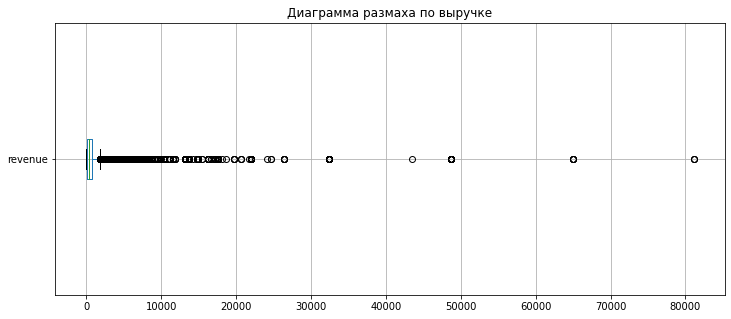

In [51]:
plt.figure(figsize=(12,5))
df.boxplot(column='revenue', vert=False, grid=True, figsize=(12,6))
plt.title('Диаграмма размаха по выручке')
plt.show()

Видно что большое количество выбросов:  
медиана - 356, среднее значение 625.584, когда максимальное значение 81174.

На диаграмме наглядно видно выбросы.

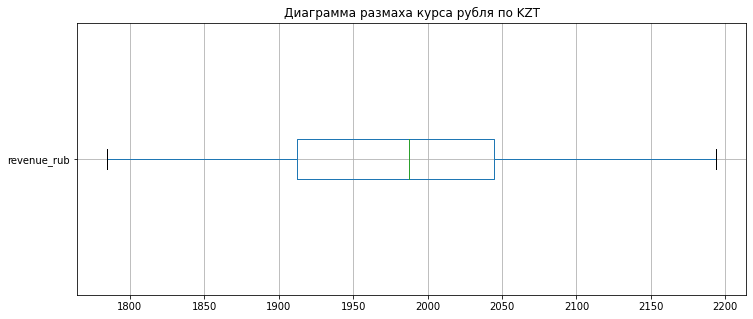

In [52]:
plt.figure(figsize=(12,5))
df_kzt.boxplot(column='revenue_rub', vert=False, grid=True, figsize=(12,6))
plt.title('Диаграмма размаха курса рубля по KZT')
plt.show()

**На диаграмме видно что выбросы отсутвствуют**

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [53]:
# Основные данные
sorted_transactions = df.copy()
sorted_transactions = sorted_transactions.sort_values(['user_id', 'order_dt'])

# Базовый профиль пользователя
user_base_profile = sorted_transactions.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    orders_count=('order_id', 'nunique')
).reset_index()

# Данные первого заказа каждого пользователя
first_order_details = sorted_transactions.drop_duplicates(subset='user_id', keep='first')
first_order_details = first_order_details[['user_id', 'device_type_canonical', 'region_name', 
                                           'service_name', 'event_type_main']]

# Объединяем базовый профиль с деталями первого заказа
user_profile = pd.merge(user_base_profile, first_order_details, on='user_id')

# ===== Конвертация валюты =====
# Подготовка дат
sorted_transactions['order_date_only'] = sorted_transactions['order_dt'].dt.date
df_kzt['rate_date'] = pd.to_datetime(df_kzt['data']).dt.date

# Добавляем курсы валют
transactions_with_rates = sorted_transactions.merge(
    df_kzt[['rate_date', 'curs']],
    left_on='order_date_only',
    right_on='rate_date',
    how='left'
)

# Конвертируем выручку в рубли
transactions_with_rates['revenue_in_rub'] = transactions_with_rates.apply(
    lambda row: (row['revenue'] / 100) * row['curs'] if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

# ===== Средние значения =====
grouped_metrics = transactions_with_rates.groupby('user_id')

user_metrics = pd.DataFrame({
    'avg_revenue_rub': grouped_metrics['revenue_in_rub'].mean(),
    'avg_tickets_per_order': grouped_metrics['tickets_count'].mean(),
    'avg_days_between_orders': grouped_metrics['days_since_prev'].mean()
}).reset_index()

# Добавляем метрики к профилю
user_profile = pd.merge(user_profile, user_metrics, on='user_id', how='left')

# ===== Бинарные признаки =====
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int)

# ===== Результат =====
print("\nПервые 10 пользователей:")
print(user_profile.head(10))


Первые 10 пользователей:
           user_id first_order_date last_order_date  orders_count  \
0  0002849b70a3ce2       2024-08-20      2024-08-20             1   
1  0005ca5e93f2cf4       2024-07-23      2024-10-06             2   
2  000898990054619       2024-07-13      2024-10-23             3   
3  00096d1f542ab2b       2024-08-15      2024-08-15             1   
4  000a55a418c128c       2024-09-29      2024-10-15             2   
5  000cf0659a9f40f       2024-06-20      2024-06-21            13   
6  00147c9209d45d3       2024-06-25      2024-06-25             2   
7  0018ecd8a38a51b       2024-07-25      2024-07-25             1   
8  00199a573901564       2024-06-17      2024-06-17             1   
9  001e7037d013f0f       2024-07-04      2024-09-29             3   

  device_type_canonical           region_name        service_name  \
0                mobile    Каменевский регион        Край билетов   
1                mobile    Каменевский регион           Мой билет   
2      

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

Общее число пользователей
21933
Доля пользователей, совершивших 2 и более заказа
13559
Доля пользователей, совершивших 5 и более заказа
6400
Общее число заказов
290611


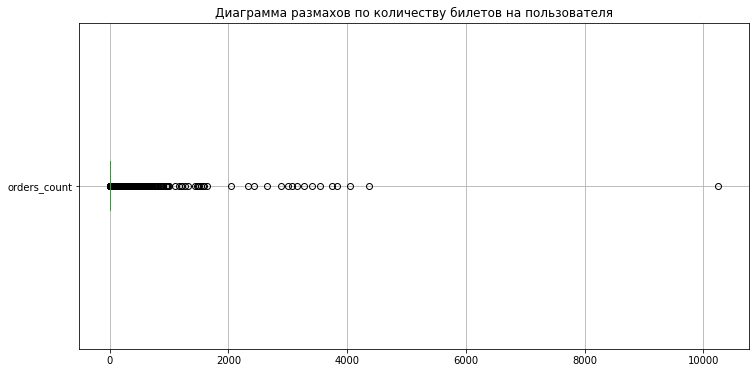

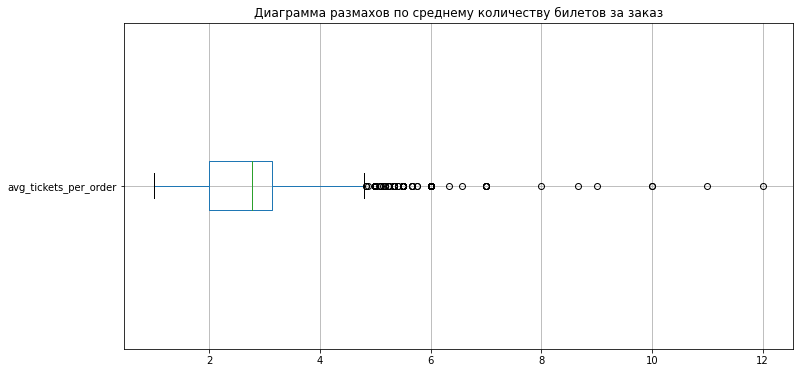

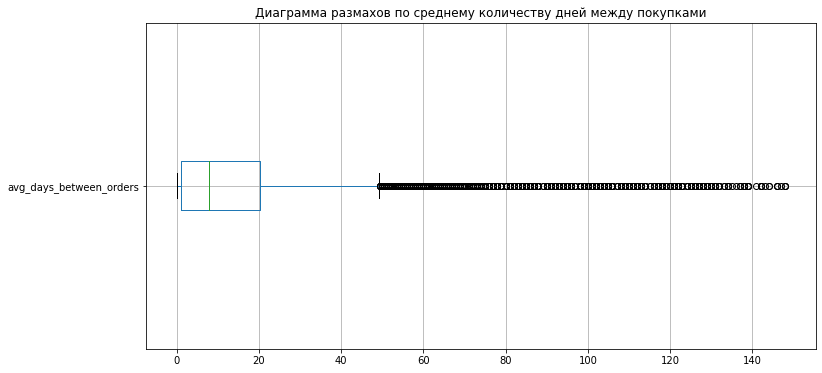

In [54]:
print('Общее число пользователей')
print(user_profile.shape[0])

print('Доля пользователей, совершивших 2 и более заказа')
print(user_profile['is_two'].sum())

print('Доля пользователей, совершивших 5 и более заказа')
print(user_profile['is_five'].sum())

print('Общее число заказов')
print(user_profile['orders_count'].sum())

plt.figure(figsize=(12,6))
user_profile.boxplot(column='orders_count', vert=False, grid=True)
plt.title('Диаграмма размахов по количеству билетов на пользователя')
plt.show()

plt.figure(figsize=(12,6))
user_profile.boxplot(column='avg_tickets_per_order', vert=False, grid=True)
plt.title('Диаграмма размахов по среднему количеству билетов за заказ')
plt.show()

plt.figure(figsize=(12,6))
user_profile.boxplot(column='avg_days_between_orders', vert=False, grid=True)
plt.title('Диаграмма размахов по среднему количеству дней между покупками')
plt.show()

Во всех трёх диаграммах видно большое количество выбросов, но по отношению выбросов дуруг к другу больше всего выделяется **"Количество билетов"** где разница между последним и предпоследним выбросом **6000+ билетов**.  
Я считаю разумным решением будет убрать значение по 99 процентилю только в 'orders_count' что бы дальнейший анализ был точнее

In [55]:
print(user_profile['orders_count'].describe())
# Вычисляем 99 перцентиль
percentile = user_profile['orders_count'].quantile(0.99)
print(f"99 перцентиль orders_count: {percentile}")
# Удаляем строки >= 99 перцентиля
user_profile_filtered = user_profile[user_profile['orders_count'] < percentile]

print(user_profile_filtered['orders_count'].describe())

count    21933.000000
mean        13.249943
std        122.470535
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10251.000000
Name: orders_count, dtype: float64
99 перцентиль orders_count: 152.0
count    21712.000000
mean         6.508290
std         14.268477
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        151.000000
Name: orders_count, dtype: float64


Общее число заказов
290611


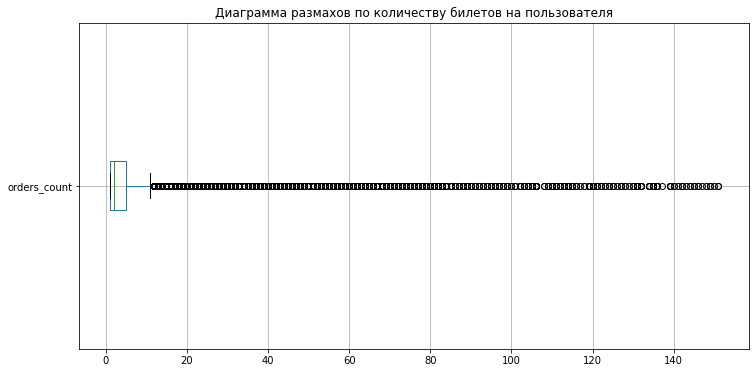

In [56]:
print('Общее число заказов')
print(user_profile['orders_count'].sum())

plt.figure(figsize=(12,6))
user_profile_filtered.boxplot(column='orders_count', vert=False, grid=True)
plt.title('Диаграмма размахов по количеству билетов на пользователя')
plt.show()

Удалив значения выше 99 процентиля (~200 строк из 22 тысяч) наглядно изменилась диаграмма размахов, теперь все выбросы не имеют огромных значений которые будут мешать при дальнейшем анализе.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


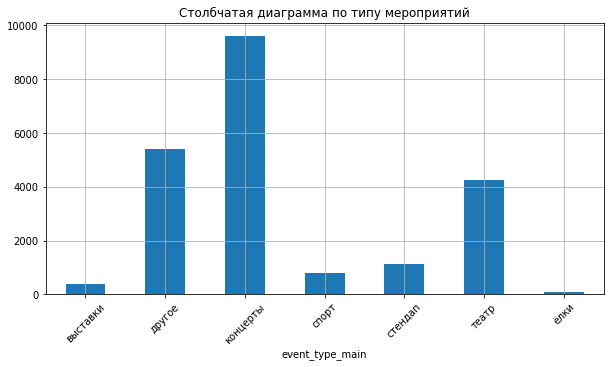

In [57]:
grouped_user_profile_filtered = user_profile_filtered.groupby('event_type_main')['user_id'].count()
grouped_user_profile_filtered.plot(kind='bar',grid=True, title='Столбчатая диаграмма по типу мероприятий',rot=45, figsize=(10,5))
plt.show()


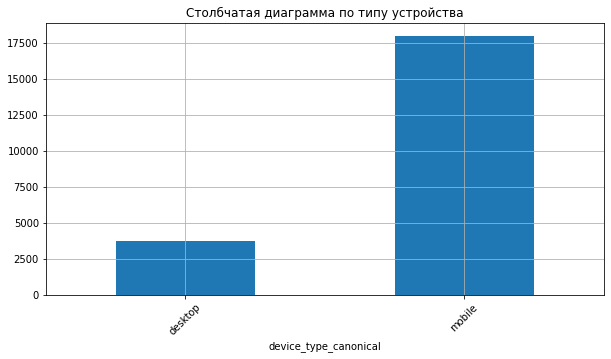

In [58]:
grouped_user_profile_filtered = user_profile_filtered.groupby('device_type_canonical')['user_id'].count()
grouped_user_profile_filtered.plot(kind='bar',grid=True, title='Столбчатая диаграмма по типу устройства',rot=45, figsize=(10,5))
plt.show()

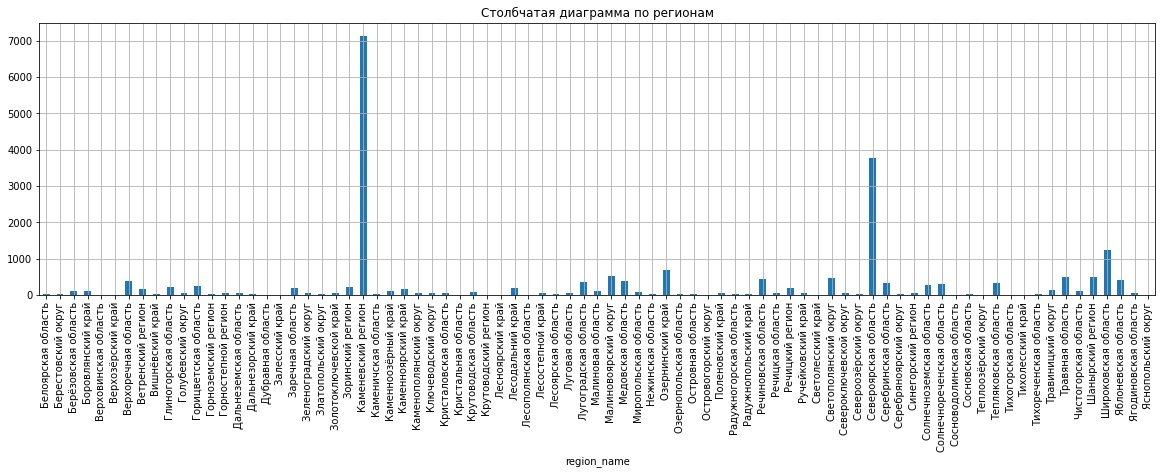

In [59]:
grouped_user_profile_filtered = user_profile_filtered.groupby('region_name')['user_id'].count()
grouped_user_profile_filtered.plot(kind='bar',grid=True, title='Столбчатая диаграмма по регионам',rot=90, figsize=(20,5))
plt.show()

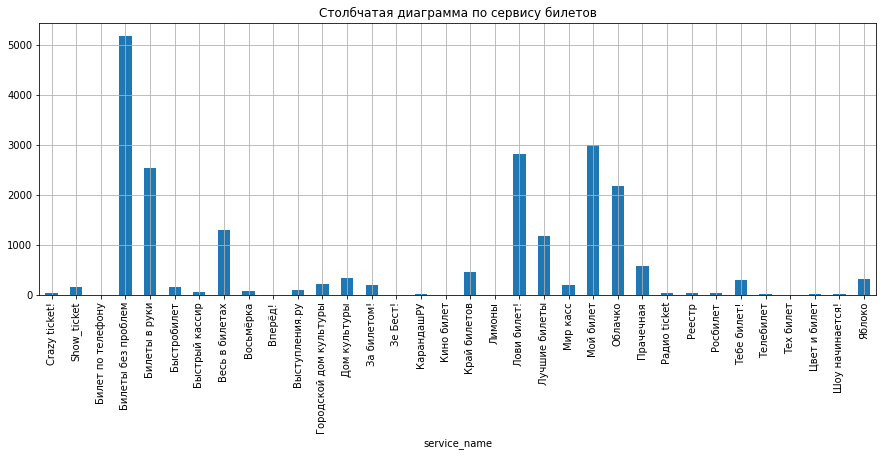

In [60]:
grouped_user_profile_filtered = user_profile_filtered.groupby('service_name')['user_id'].count()
grouped_user_profile_filtered.plot(kind='bar',grid=True, title='Столбчатая диаграмма по сервису билетов',rot=90, figsize=(15,5))
plt.show()

In [61]:
for i in ['event_type_main','device_type_canonical','region_name','service_name']:
    counts = user_profile_filtered[i].value_counts()
    total = len(user_profile_filtered)
    percentages = (counts / total * 100).round(2)

    result_table = pd.DataFrame({
        'Количество': counts,
        'Доля (%)': percentages
    })
    print(result_table)
    print('')

          Количество  Доля (%)
концерты        9617     44.29
другое          5420     24.96
театр           4267     19.65
стендап         1115      5.14
спорт            798      3.68
выставки         401      1.85
ёлки              94      0.43

         Количество  Доля (%)
mobile        17955      82.7
desktop        3757      17.3

                          Количество  Доля (%)
Каменевский регион              7132     32.85
Североярская область            3763     17.33
Широковская область             1237      5.70
Озернинский край                 673      3.10
Малиновоярский округ             528      2.43
...                              ...       ...
Тихогорская область                2      0.01
Светолесский край                  2      0.01
Верхозёрский край                  1      0.00
Яснопольский округ                 1      0.00
Сосноводолинская область           1      0.00

[81 rows x 2 columns]

                        Количество  Доля (%)
Билеты без проблем         

Выводы по каждому сегменту пользователей: 
- **Тип мероприятий:** "Концерты" явные лидеры 9600 (44%) почти половина пользователей, самыми невосребованными являются "Ёлки" (0.43%), скорее всего из-за того что "Елки" сезонное мероприятие, а театры актуальны круглый год;
- **Тип устройсва:** "Телефон" абсолютный лидер в сегменте почти 18000 (82%);
- **Регион:** "Каменевский регион" - 7132 пользователей (32.85%) и "Североярская область" - 3763 пользователей (17.33%) это два лидера по регионам;
- **Сервис покупки билетов:** "Билеты без проблем" - 5183 пользователь(23.87%) лидер по сервисам покупки билетов

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Средняя доля возвратов: 61.4%

1. По типу мероприятия:
is_two           доля_возвратов_%
event_type_main                  
театр                   63.510663
выставки                62.842893
концерты                62.067173
стендап                 60.896861
другое                  59.612546
спорт                   55.889724
ёлки                    54.255319


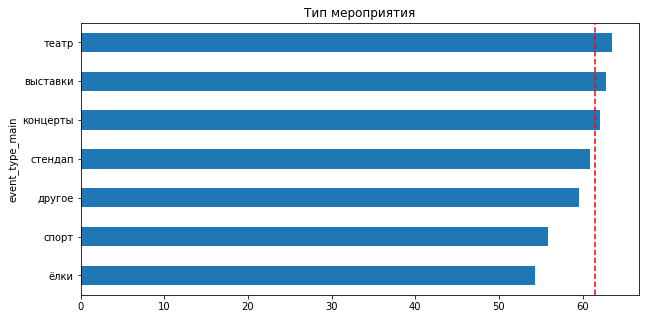

In [62]:
avg_return = user_profile_filtered['is_two'].mean() * 100
print(f"Средняя доля возвратов: {avg_return:.1f}%\n")

print("1. По типу мероприятия:")
event_data = user_profile_filtered.groupby('event_type_main')['is_two'].value_counts().unstack(fill_value=0)
event_data['доля_возвратов_%'] = event_data.get(1, 0) / (event_data.get(0, 0) + event_data.get(1, 0)) * 100
print(event_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

event_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(10, 5)
)
plt.axvline(avg_return, color='red', linestyle='--')
plt.title('Тип мероприятия')
plt.show()


2. По типу устройства:
is_two                 доля_возвратов_%
device_type_canonical                  
desktop                       64.093692
mobile                        60.874408


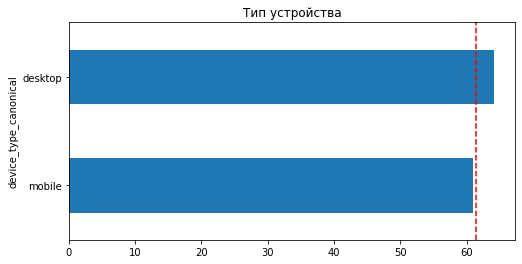

In [63]:
print("\n2. По типу устройства:")
device_data = user_profile_filtered.groupby('device_type_canonical')['is_two'].value_counts().unstack(fill_value=0)
device_data['доля_возвратов_%'] = device_data.get(1, 0) / (device_data.get(0, 0) + device_data.get(1, 0)) * 100
print(device_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

device_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(8, 4)
)
plt.axvline(avg_return, color='red', linestyle='--')
plt.title('Тип устройства')
plt.show()


3. По региону (топ-10):
is_two                доля_возвратов_%
region_name                           
Шанырский регион             68.127490
Светополянский округ         65.874730
Широковская область          64.915117
Североярская область         63.938347
Речиновская область          63.448276
Каменевский регион           62.450925
Травяная область             61.396304
Яблоневская область          59.223301
Малиновоярский округ         55.871212
Озернинский край             54.829123


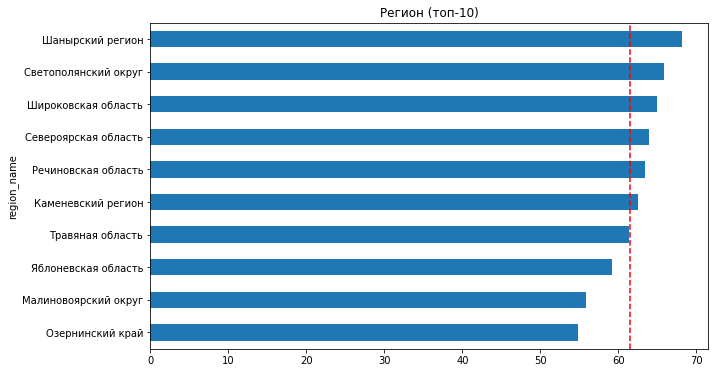

In [64]:
print("\n3. По региону (топ-10):")
top_regions = user_profile_filtered['region_name'].value_counts().head(10).index
region_filtered = user_profile_filtered[user_profile_filtered['region_name'].isin(top_regions)]

region_data = region_filtered.groupby('region_name')['is_two'].value_counts().unstack(fill_value=0)
region_data['доля_возвратов_%'] = region_data.get(1, 0) / (region_data.get(0, 0) + region_data.get(1, 0)) * 100
print(region_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

region_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(10, 6)
)
plt.axvline(avg_return, color='red', linestyle='--')
plt.title('Регион (топ-10)')
plt.show()


4. По билетному оператору (топ-10):
is_two              доля_возвратов_%
service_name                        
Край билетов               65.509761
Дом культуры               63.768116
Весь в билетах             63.190184
Билеты в руки              62.593320
Прачечная                  61.979167
Облачко                    61.315547
Лучшие билеты              61.284869
Лови билет!                61.280057
Мой билет                  61.138861
Билеты без проблем         60.428323


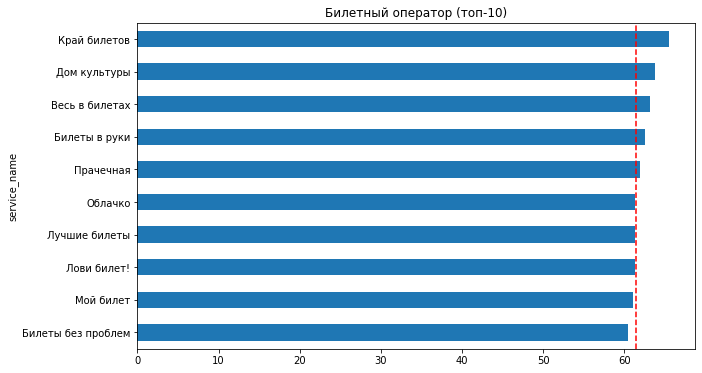

In [65]:
print("\n4. По билетному оператору (топ-10):")
top_services = user_profile_filtered['service_name'].value_counts().head(10).index
service_filtered = user_profile_filtered[user_profile_filtered['service_name'].isin(top_services)]

service_data = service_filtered.groupby('service_name')['is_two'].value_counts().unstack(fill_value=0)
service_data['доля_возвратов_%'] = service_data.get(1, 0) / (service_data.get(0, 0) + service_data.get(1, 0)) * 100
print(service_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

service_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(10, 6)
)
plt.axvline(avg_return, color='red', linestyle='--')
plt.title('Билетный оператор (топ-10)')
plt.show()

Тип мероприятия:
  Лучший: театр (63.5% возвратов, 4267 пользователей)

Тип устройства:
  Лучший: desktop (64.1% возвратов, 3757 пользователей)

Регион:
  Лучший: Шанырский регион (68.1% возвратов, 502 пользователей)

Оператор:
  Лучший: Край билетов (65.5% возвратов, 461 пользователей)

Успешные точки входа (>100 пользователей): 4
  - Тип мероприятия: театр (63.5%)
  - Тип устройства: desktop (64.1%)
  - Регион: Шанырский регион (68.1%)
  - Оператор: Край билетов (65.5%)

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [66]:
sport_users = user_profile_filtered[user_profile_filtered['event_type_main'] == 'спорт']
concert_users = user_profile_filtered[user_profile_filtered['event_type_main'] == 'концерты']

sport_return = sport_users['is_two'].mean() * 100
concert_return = concert_users['is_two'].mean() * 100

print(f"Спортивные мероприятия: {sport_return:.1f}% возвратов ({len(sport_users)} пользователей)")
print(f"Концерты: {concert_return:.1f}% возвратов ({len(concert_users)} пользователей)")

# Сравниваем
if sport_return > concert_return:
    print(f"Гипотеза 1 ПОДТВЕРЖДАЕТСЯ: спорт ({sport_return:.1f}%) > концерты ({concert_return:.1f}%)")
else:
    print(f"Гипотеза 1 ОПРОВЕРГАЕТСЯ: спорт ({sport_return:.1f}%) ≤ концерты ({concert_return:.1f}%)")

Спортивные мероприятия: 55.9% возвратов (798 пользователей)
Концерты: 62.1% возвратов (9617 пользователей)
Гипотеза 1 ОПРОВЕРГАЕТСЯ: спорт (55.9%) ≤ концерты (62.1%)


In [67]:
# 1. Находим самые активные регионы (топ-3 по количеству пользователей)
top_regions = user_profile_filtered['region_name'].value_counts().head(3).index
print(f"Самые активные регионы (топ-3): {list(top_regions)}")

# 2. Остальные регионы
other_regions = user_profile_filtered[~user_profile_filtered['region_name'].isin(top_regions)]

# 3. Считаем доли возвратов
active_return = user_profile_filtered[user_profile_filtered['region_name'].isin(top_regions)]['is_two'].mean() * 100
other_return = other_regions['is_two'].mean() * 100

print(f"\nАктивные регионы (топ-3): {active_return:.1f}% возвратов")
print(f"Остальные регионы: {other_return:.1f}% возвратов")

# 4. Сравниваем
if active_return > other_return:
    print(f"Гипотеза 2 ПОДТВЕРЖДАЕТСЯ: активные регионы ({active_return:.1f}%) > остальные ({other_return:.1f}%)")
else:
    print(f"Гипотеза 2 ОПРОВЕРГАЕТСЯ: активные регионы ({active_return:.1f}%) ≤ остальные ({other_return:.1f}%)")

Самые активные регионы (топ-3): ['Каменевский регион', 'Североярская область', 'Широковская область']

Активные регионы (топ-3): 63.2% возвратов
Остальные регионы: 59.2% возвратов
Гипотеза 2 ПОДТВЕРЖДАЕТСЯ: активные регионы (63.2%) > остальные (59.2%)


Выводы:  
**Гипотеза 1 ОПРОВЕРГАЕТСЯ: спорт (55.9%) ≤ концерты (62.1%)**  
**Гипотеза 2 ПОДТВЕРЖДАЕТСЯ: активные регионы (63.2%) > остальные (59.2%)**

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


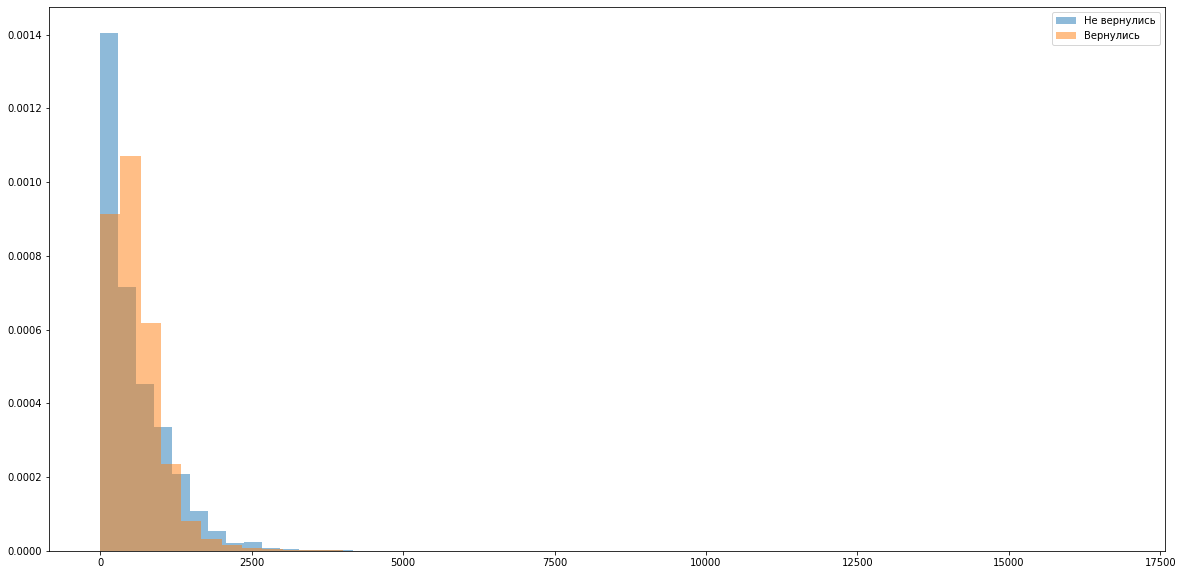

In [68]:
one_order_users = user_profile_filtered[user_profile_filtered['is_two']==0]
returned_users  = user_profile_filtered[user_profile_filtered['is_two']==1]

revenue_one_order = one_order_users['avg_revenue_rub']
revenue_returned = returned_users['avg_revenue_rub']

plt.figure(figsize=(20,10))
plt.hist(revenue_one_order, bins=50, alpha=0.5, label='Не вернулись', density=True)
plt.hist(revenue_returned, bins=50, alpha=0.5, label='Вернулись', density=True)
plt.legend()
plt.show()




1. В каких диапазонах концентрируются пользователи?

Обе группы: 0-2000 рублей (особенно 500-1000 руб)  

Это типичный диапазон средней выручки заказа  

2. Есть ли различия между группами?

Да, но небольшие: Вернувшиеся пользователи имеют:

Немного более высокую среднюю выручку

Более выраженный "хвост" распределения в области высоких значений

Чуть больше пользователей в диапазоне 1000-3000 рублей

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


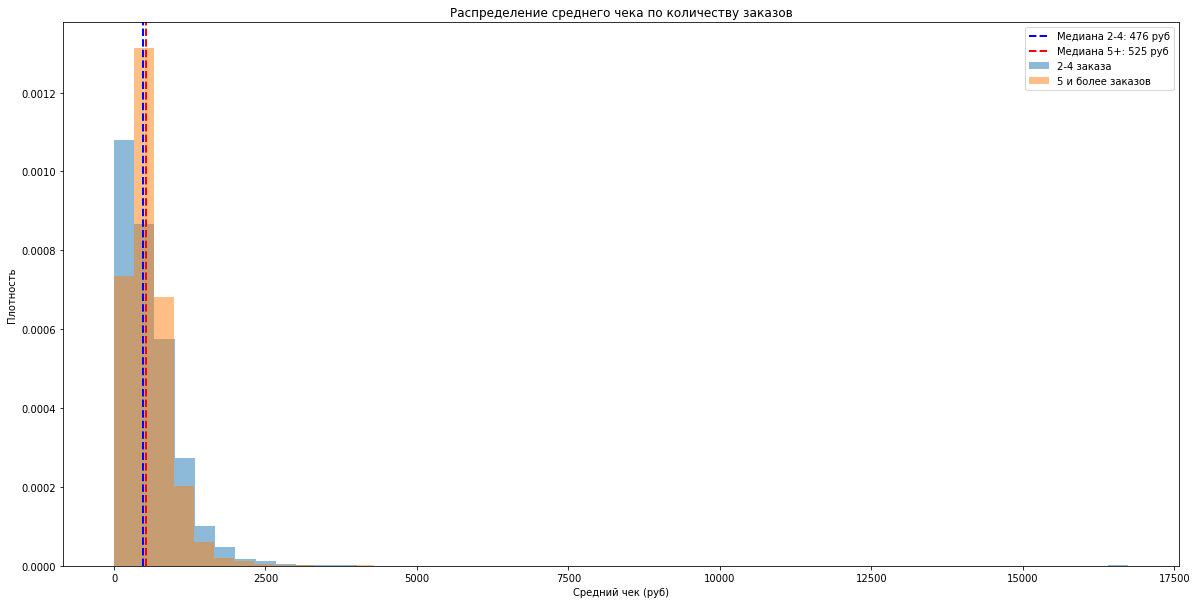

In [69]:
orders_2_4 = user_profile_filtered[(user_profile_filtered['is_two']==1) & (user_profile_filtered['is_five']==0)]
orders_5_more  = user_profile_filtered[(user_profile_filtered['is_two']==1) & (user_profile_filtered['is_five']==1)]

revenue_orders_2_4 = orders_2_4['avg_revenue_rub']
revenue_orders_5_more = orders_5_more['avg_revenue_rub']

plt.figure(figsize=(20,10))

plt.hist(revenue_orders_2_4, bins=50, alpha=0.5, label='2-4 заказа', density=True)
plt.hist(revenue_orders_5_more, bins=50, alpha=0.5, label='5 и более заказов', density=True)

median_2_4 = revenue_orders_2_4.median()
median_5_more = revenue_orders_5_more.median()

plt.axvline(median_2_4, color='blue', linestyle='--', linewidth=2, 
            label=f'Медиана 2-4: {median_2_4:.0f} руб')
plt.axvline(median_5_more, color='red', linestyle='--', linewidth=2, 
            label=f'Медиана 5+: {median_5_more:.0f} руб')

plt.legend()
plt.xlabel('Средний чек (руб)')
plt.ylabel('Плотность')
plt.title('Распределение среднего чека по количеству заказов')
plt.show()


Различия есть, но они НЕЗНАЧИТЕЛЬНЫЕ.

Пользователи с 5+ заказами имеют среднюю выручку на ~10% выше (52.5 руб vs 47.6 руб), но в абсолютном выражении разница всего ~5 рублей.

Вывод: Количество заказов слабо влияет на среднюю выручку. Основной рост выручки происходит при переходе от 1 заказа к 2+, а между группами 2-4 и 5+ заказов разница минимальна.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

от 2 до 3 билетов       9430
от 3 до 5 билетов       9192
от 1 до 2 билетов       2401
от 5 и более билетов     689
Name: ticket_segment, dtype: int64


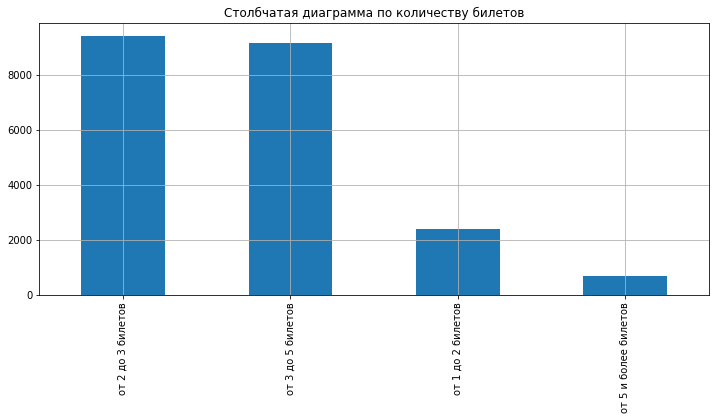

In [70]:
avg_tickets_count_filter = user_profile_filtered.copy()

# Создаем функцию для определения сегмента
def get_ticket_segment(tickets):
    if 1 <= tickets < 2:
        return 'от 1 до 2 билетов'
    elif 2 <= tickets < 3:
        return 'от 2 до 3 билетов'
    elif 3 <= tickets < 5:
        return 'от 3 до 5 билетов'
    elif tickets >= 5:
        return 'от 5 и более билетов'
    else:
        return 'Ошибка'

# Применяем функцию к колонке avg_tickets_count
avg_tickets_count_filter['ticket_segment'] = avg_tickets_count_filter['avg_tickets_per_order'].apply(get_ticket_segment)

print(avg_tickets_count_filter['ticket_segment'].value_counts())

plt.figure(figsize=(12,5))
avg_tickets_count_filter['ticket_segment'].value_counts().plot.bar(title='Столбчатая диаграмма по количеству билетов', grid = True)
plt.show()

Как распределены пользователи по сегментам — равномерно или сконцентрировано?  
**Пользователи сконцентрированны в двух сегментах "от 2 до 3" и "от 3 до 5" в обоих случая более 9000 пользователей**  

Есть ли сегменты с аномально высокой или низкой долей повторных покупок?  
**Сегменты без аномальных сегменты, все сегменты выглядят реалстично**  

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [71]:
import datetime

date_analis = user_profile_filtered.copy()
#день недели первой покупки
date_analis['week_day_of_first_order'] = date_analis['first_order_date'].dt.day_of_week + 1
#время с момента первой покупки — лайфтайм
last_day = date_analis['last_order_date'].max()
today = pd.Timestamp.today()
date_analis['day_counter_from_first_order'] = (last_day - date_analis['first_order_date']).dt.days
print(date_analis[['week_day_of_first_order','day_counter_from_first_order','avg_days_between_orders']])

       week_day_of_first_order  day_counter_from_first_order  \
0                            2                            72   
1                            2                           100   
2                            6                           110   
3                            4                            77   
4                            7                            32   
...                        ...                           ...   
21928                        2                           107   
21929                        4                            77   
21930                        4                           133   
21931                        2                            37   
21932                        3                            36   

       avg_days_between_orders  
0                          NaN  
1                       75.000  
2                       51.000  
3                          NaN  
4                       16.000  
...                        ...  


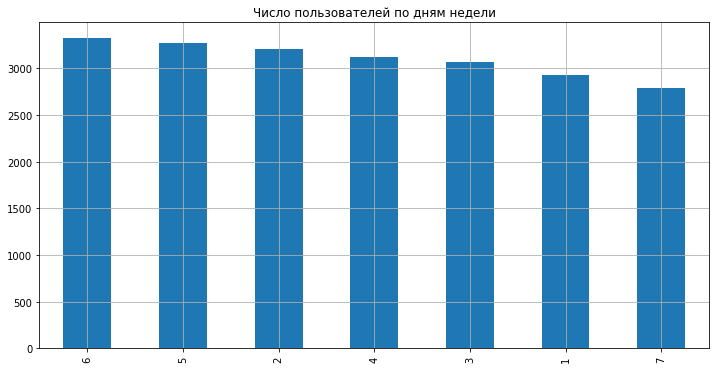

In [72]:
plt.figure(figsize=(12,6))
date_analis['week_day_of_first_order'].value_counts().plot(kind='bar', title='Число пользователей по дням недели', grid=True)
plt.show()

Исходя из проделанного анализа можно сказать что количество пользователей распределенно равномерно по дням недели (разница между первым и последним местом ~600), но первое место занимает - суббота, а последнее - воскресенье.

interval columns not set, guessing: ['week_day_of_first_order', 'is_two']
                         week_day_of_first_order    is_two
week_day_of_first_order                 1.000000  0.022144
is_two                                  0.022144  1.000000


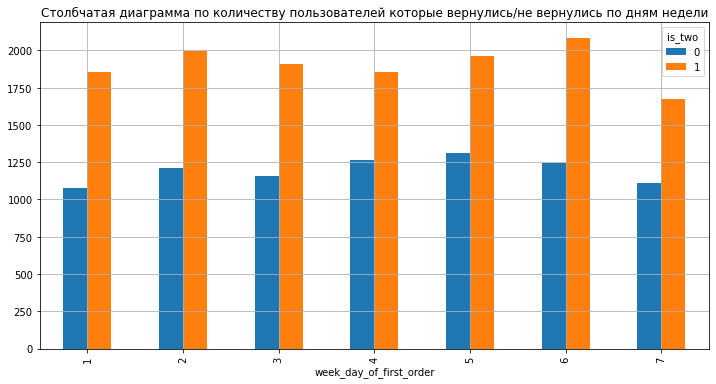

Доля возвратов по дням недели (%):
week_day_of_first_order
1    63.211729
2    62.285357
3    62.300424
4    59.494076
5    59.902200
6    62.657847
7    60.122039
Name: is_two, dtype: float64


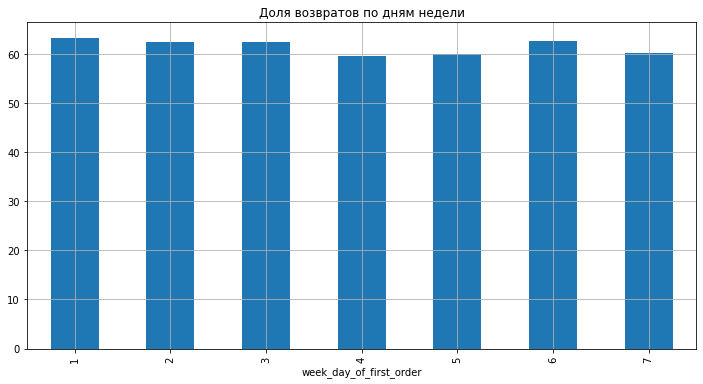

In [73]:
print(date_analis[['week_day_of_first_order','is_two']].phik_matrix())


date_analis.groupby('week_day_of_first_order')['is_two'].value_counts().unstack(fill_value=0).plot(kind='bar',figsize=(12,6), title='Столбчатая диаграмма по количеству пользователей которые вернулись/не вернулись по дням недели', grid=True)
plt.show()

return_by_day = date_analis.groupby('week_day_of_first_order')['is_two'].mean() * 100
print("Доля возвратов по дням недели (%):")
print(return_by_day)

# График доли возвратов
plt.figure(figsize=(12,6))
return_by_day.plot(kind='bar', title='Доля возвратов по дням недели',grid=True)
plt.show()

Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?  

**Основываясь на диаграммах и матрице корреляции можно сказать что зависимости от дня недели и возвращении клиентов - нет**

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


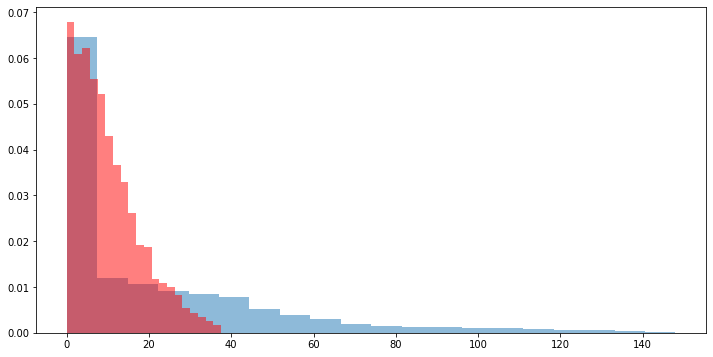

Средний интервал (2-4): 21.326324462890625 дней
Средний интервал (5+): 9.964202880859375 дней


In [74]:
avg_days_orders_2_4 = orders_2_4['avg_days_between_orders']
avg_days_orders_5_more = orders_5_more['avg_days_between_orders']

plt.figure(figsize=(12,6))
plt.hist(avg_days_orders_2_4, bins=20, alpha=0.5, label='2-4 заказа', density=True)
plt.hist(avg_days_orders_5_more, bins=20, alpha=0.5, label='5+ заказов', density=True, color='red')
plt.show()

# Сравнить средние интервалы
print(f"Средний интервал (2-4): {avg_days_orders_2_4.mean()} дней")
print(f"Средний интервал (5+): {avg_days_orders_5_more.mean()} дней")


**Основываясь на исследовании данных можно сказать что чем меньше среднее число дней между заказами тем больше вероятность стать активным пользователем**

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

Распределение orders_count:
1    8374
2    3582
3    2176
4    1401
5     980
Name: orders_count, dtype: int64

Доля пользователей с 1 заказом: 38.6%

Корреляция order_segment с другими признаками:
order_segment              1.000000
avg_days_between_orders    0.465731
avg_tickets_per_order      0.404627
region_name                0.125094
avg_revenue_rub            0.080052
service_name               0.075357
event_type_main            0.039195
device_type_canonical      0.019454
Name: order_segment, dtype: float64


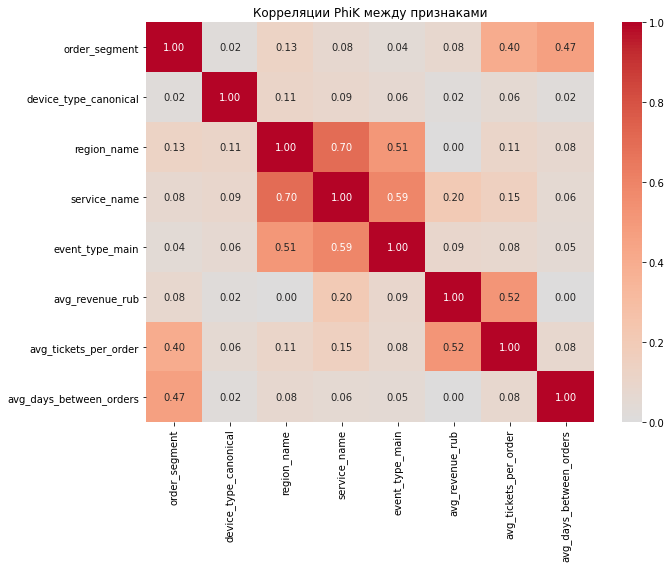

In [75]:

corr_data = user_profile_filtered.copy()


print("Распределение orders_count:")
print(corr_data['orders_count'].value_counts().head())
one_order_ratio = (corr_data['orders_count'] == 1).mean() * 100
print(f"\nДоля пользователей с 1 заказом: {one_order_ratio:.1f}%")


def create_segment(orders):
    if orders == 1:
        return '1 заказ'
    elif 2 <= orders <= 4:
        return '2-4 заказа'
    else:  # 5 и более
        return '5+ заказов'

corr_data['order_segment'] = corr_data['orders_count'].apply(create_segment)


features = [
    'order_segment',          
    'device_type_canonical', 
    'region_name',         
    'service_name',          
    'event_type_main',      
    'avg_revenue_rub',        
    'avg_tickets_per_order',   
    'avg_days_between_orders' 
]


corr_matrix = corr_data[features].phik_matrix(
    interval_cols=['avg_revenue_rub', 'avg_tickets_per_order', 'avg_days_between_orders']
)


print("\nКорреляция order_segment с другими признаками:")
print(corr_matrix['order_segment'].sort_values(ascending=False))


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляции PhiK между признаками')
plt.tight_layout()
plt.show()

**Распределение пользователей:**
38.6% пользователей совершили 1 заказ

**Распределение неравномерное:** с ростом количества заказов число пользователей уменьшается

**Наиболее связанные с количеством заказов признаки:**  
**Сильная связь (>0.3):**

avg_days_between_orders (0.47) — самая сильная связь

avg_tickets_per_order (0.40)

**Умеренная связь (0.1-0.3):**  
3. region_name (0.13)

**Слабая связь (<0.1):**  
4. avg_revenue_rub (0.08)
5. service_name (0.08)
6. event_type_main (0.04)
7. device_type_canonical (0.02)

**Ответ на вопрос:**  
Наиболее связаны с количеством заказов: средний интервал между заказами и среднее количество билетов в заказе.

Практически не влияют: тип устройства, тип мероприятия, билетный оператор (очень слабая связь).

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Общие выводы и рекомендации**

 **1. Информация о данных и их подготовка**
- **Объём данных:** 290,611 транзакций от 21,933 пользователей
- **Подготовка данных:**
  - Конвертирована выручка из KZT в RUB по актуальным курсам
  - Оптимизированы типы данных для экономии памяти
  - Отфильтрованы выбросы по 99-му перцентилю (удалено 1% пользователей с аномально большим количеством заказов)
  - Создан профиль пользователей с агрегированными признаками

 **2. Основные результаты анализа**

 **2.1. Статистика пользователей**
- **Распределение по заказам:** 38.6% пользователей совершили только 1 заказ, 29.2% - 2-4 заказа, 29.5% - 5+ заказов
- **Активность:** 61.4% пользователей совершили 2+ заказа, 29.5% - 5+ заказов
- **Средние показатели:**
  - Средний интервал между заказами: 13.2 дня
  - Средний чек: 625.6 руб
  - Среднее количество билетов в заказе: 2.8

 **2.2. Признаки первого заказа и возвраты**
- **Наиболее влияющие на возврат:**
  - **Тип устройства:** Desktop-пользователи возвращаются чаще (64.1% vs 60.9% на mobile)
  - **Тип мероприятия:** Театральные мероприятия имеют самую высокую долю возвратов (63.5%)
  - **Регион:** Шанырский регион лидирует по возвратам (68.1%)
  - **Билетный оператор:** "Край билетов" показывает лучшие результаты (65.5%)

- **Опровергнутая гипотеза:** Спортивные мероприятия имеют **ниже** долю возвратов (55.9%) по сравнению с концертами (62.1%)

**2.3. Влияние финансовых показателей**
- **Средняя выручка:** Пользователи с 2+ заказами имеют немного более высокую среднюю выручку
- **Количество билетов:** Пользователи, покупающие 2-5 билетов за раз, более лояльны
- **Ключевая зависимость:** Чем **меньше интервал между заказами**, тем **больше общее количество заказов** (сильная корреляция 0.47)

 **2.4. Временные характеристики**
- **День недели:** Практически не влияет на вероятность возврата (слабая корреляция 0.022)
- **Интервалы между заказами:** Наиболее значимый фактор:
  - Пользователи с 2-4 заказами: средний интервал 21.3 дня
  - Пользователи с 5+ заказами: средний интервал 10.0 дней (в 2 раза чаще!)

 **2.5. Корреляционный анализ**
- **Сильнее всего с количеством заказов связаны:**
  1. Средний интервал между заказами (0.47)
  2. Среднее количество билетов в заказе (0.40)
- **Практически не влияют:**
  - Тип устройства первого заказа (0.02)
  - Тип первого мероприятия (0.04)
  - Билетный оператор (0.08)

 **3. Рекомендации для заказчика**

 **3.1. Приоритетные направления**
1. **Уменьшение интервала между заказами** — ключевой драйвер роста лояльности
   - Внедрить программы лояльности
   - Рассмотреть подписки на мероприятия
   - Персонализированные рекомендации

2. **Стимулирование покупки большего количества билетов**
   - Скидки на групповые покупки
   - Программы "приведи друга"
   - Семейные абонементы

3. **Фокус на успешных сегментах:**
   - Desktop-пользователи (выше конверсия в повторные покупки)
   - Театральные мероприятия (самые лояльные посетители)
   - Регионы-лидеры (Шанырский, Североярская область)


**Главный вывод:** Частота покупок (интервал между заказами) — наиболее значимый фактор лояльности. Пользователи, совершающие покупки чаще чем раз в 10 дней, в 2 раза чаще становятся активными клиентами (5+ заказов).

**Рекомендуемая стратегия:** Сфокусироваться на превращении "разовых" покупателей в "регулярных" через сокращение интервала между покупками, а не только на привлечении новых пользователей.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**